# Transformer Based Sentiment Classification
In this notebook, the sentiment classification task is pushed to the limit using the encoder used in the "Attention is all you need" paper. The dataset used is the IMDB dataset.
## Sections:
- [Dataset Importing and Utilities](#Dataset-Importing-and-Utilities)
- [Preprocessing](#Preprocessing)
- [Positional Encoding](#Positional-Encoding)
- [Transformer Encoder Block](#Transformer-Encoder-Block)
- [Model](#Model)
- [Training Setup](#Training-Setup)
- [Loading Model Parameters and Model Evaluation](#Loading-Model-Parameters-and-Model-Evaluation)

## Dataset Importing and Utilities
The dataset used is IMDB dataset from keras datasets. A helper class was made to decode tokens and encode text.

-- MATPLOTLIB TEST

In [1]:
import matplotlib.pyplot as plt

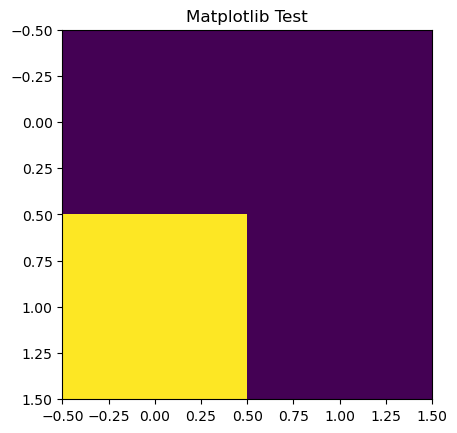

In [2]:
plt.title("Matplotlib Test")
plt.imshow([
    [0, 0],
    [1, 0]
])

Import IMDB dataset using keras

In [3]:
from tensorflow.keras.datasets.imdb import load_data
from tensorflow.keras.datasets.imdb import get_word_index

##### Specifying Dataset Parameters

In [4]:
NUM_WORDS = None
MAX_LEN = 101
SKIP_TOP = 0
START_CHAR = 1
OOV_CHAR = 2
INDEX_FROM = 3

##### Loading Dataset

In [5]:
(x_train, y_train), (x_test, y_test) = load_data(
    num_words=NUM_WORDS,
    skip_top=SKIP_TOP,
    maxlen=MAX_LEN,
    start_char=START_CHAR,
    oov_char=OOV_CHAR,
    index_from=INDEX_FROM,
)
word_index = get_word_index()

The following class performs some functionalities:
1) Decode text given word indices of each word
2) Encode text to word indices given strings of words
3) Calculating Vocabulary Size (number of tokens)

In [60]:
class DatasetUtils:
    def __init__(self, word_index, start_char=1, oov_char=2, index_from=3):
        self.start_char = start_char
        self.oov_char = oov_char
        self.index_from = index_from
        self.word_index = word_index
        self.word_index_rev = {value: key for key, value in word_index.items()}
        
    def decode(self, 
               texts, 
               skip_special_tokens=False):
        
        if len(texts.shape) == 1:
            texts = [texts]
        
        output  = []
        
        for text in texts:
            words = []
            for word_index in text:
                word_index = int(word_index)
                if word_index == self.start_char:
                    if not skip_special_tokens:
                        words.append("<START>")
                elif word_index == self.oov_char:
                    if not skip_special_tokens:
                        words.append("<OOV>")
                elif word_index == self.word_index["br"] + self.index_from:
                    if not skip_special_tokens:
                        words.append("<BR>")
                elif word_index == 0:
                    if not skip_special_tokens:
                        words.append("<PAD>")
                else:
                    words.append(self.word_index_rev[word_index - self.index_from])
            
            output.append(" ".join(words))
        
        return output
    
    def encode(self, texts, 
               add_start_char=True, 
               split_by=" ", 
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        
        if type(texts) == str:
            texts = [texts]
        
        output = []
        
        for text in texts:
            words_encoded = []
            
            words_original = text.split(split_by)
            
            if add_start_char and words_original[0] != "<START>":
                words_encoded.append(self.start_char)
                
            for word in words_original:
                if word == "<START>":
                    words_encoded.append(self.start_char)
                elif word == "<BR>":
                    words_encoded.append(self.word_index["br"] + self.index_from)
                elif word == "<PAD>":
                    words_encoded.append(0)
                else:
                    word = word.lower()
                    for f in filters:
                        if f in word:
                            word = word.replace(f, "")
                    if word not in self.word_index:
                        words_encoded.append(self.oov_char)
                    else:
                        words_encoded.append(self.word_index[word.lower()] + self.index_from)
                    
            output.append(words_encoded)
            
        return output
    
    def get_vocab_size(self):
        return max(self.word_index_rev)

In [61]:
utils = DatasetUtils(word_index)

In [8]:
utils.decode(utils.encode("<START> This movie is amazing!!"))

['<START> this movie is amazing']

In [9]:
vocab_size = utils.get_vocab_size()
print(f"Vocabulary Size = {vocab_size}")

Vocabulary Size = 88584


## Preprocessing
The train and test are concatenated to become one dataset. Then padding is performed on all the sequences. Then, data split was performed/

In [10]:
import torch
import numpy as np

In [11]:
print("Training")
print(f"x_train shape = {x_train.shape}")
print("Testing")
print(f"x_test shape = {x_test.shape}")

Training
x_train shape = (2822,)
Testing
x_test shape = (3012,)


The training and testing data are concatenated as a whole to perform padding then data splitting

In [12]:
x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

#### Padding
Each sequence is padded using pytorch's pad_sequence function

In [13]:
def pad_dataset(x):
    sequences = [torch.tensor(seq) for seq in x]
    new_x = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    return new_x

In [14]:
x = pad_dataset(x)
print(f"Dataset dimension: {x.shape}")

Dataset dimension: torch.Size([5834, 100])


#### Attention Masks
Since all sequences are padded with zeros, we want the attention mechanism to give attention only to the unpaded words (words whose word index is not equal to zero). Thus, the following function returns a boolean matrix for each sequence in `x`. This attention mask will be used for multi head attention later.

In [15]:
def get_attn_masks(x, num_heads=1):
    if len(x.shape) == 1:
        x = x.unsqueeze(0)
        
    x = x.unsqueeze(1)
    # x shape: (Batch, 1, Seq)
    with torch.no_grad():
        # mask = (x != 0).int()
        # out = (1 - torch.einsum("bi,bj->bij", mask, mask)).bool() 
        out = torch.broadcast_to((x == 0), (x.shape[0], x.shape[-1], x.shape[-1]))
        out = out.repeat(num_heads, 1, 1)
    return out

In [16]:
def plot_attention(attn_matrix, size=17, title=None, colorbar=True):
    f, ax = plt.subplots(1, 1)
    f.set_figheight(17)
    f.set_figwidth(17)
    if title is not None:
        ax.set_title(title)
    im = ax.matshow(attn_mask[0], cmap="hot")
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(sample.shape[0]))
    ax.set_yticks(np.arange(sample.shape[0]))
    ax.set_xticklabels(decoded_text.split(" "), rotation="vertical")
    ax.set_yticklabels(decoded_text.split(" "))
    if colorbar:
        plt.colorbar(im)
    plt.show()

The following cell plots the attention mask for a random sequence. The black region means `False` which means that the attention mechanism needs to attend to that region, and the white region means `True` which means that the attention mechanism does not need to attend to that region.

Review:
<START> one of the most frightening game experiences ever that will make you keep the lights on next to your bed great storyline with a romantic horrific and ironic plot fans of the original resident evil will be in for a surprise of a returning character not to mention that the voice acting have drastically improved over the previous of the series don't miss out on the best of the series <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


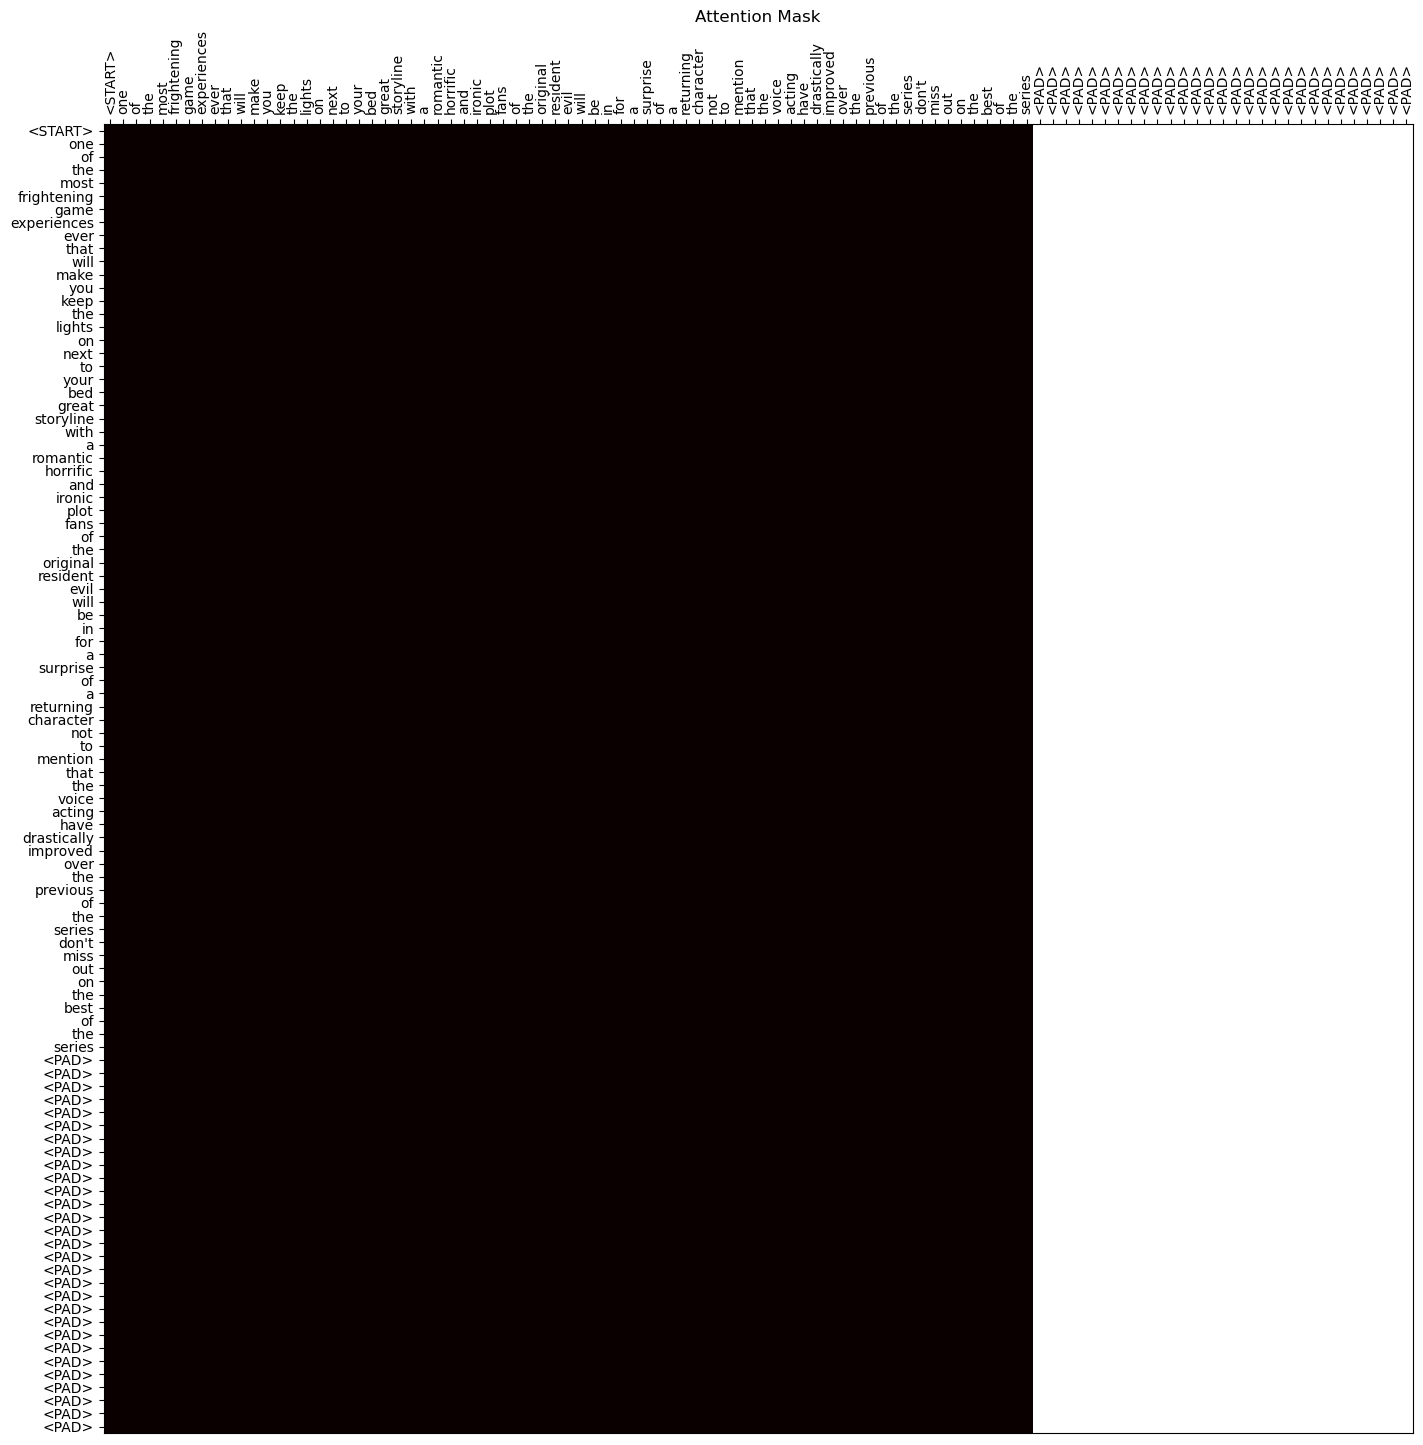

In [17]:
random_index = np.random.choice(x.shape[0])
sample = x[random_index]
decoded_text = utils.decode(sample, skip_special_tokens=False)[0]
attn_mask = get_attn_masks(sample)
attn_mask
print(f"Review:\n{decoded_text}")
plot_attention(attn_mask, title="Attention Mask", colorbar=False)

#### Data Splitting
Split 60% for train, 20% for validation, & 20% for test

In [18]:
random_idx = np.random.permutation(x.shape[0])
x = x[random_idx]
y = y[random_idx]

In [19]:
m = x.shape[0]
m_train = int(m * 0.6)
m_val = int(m * 0.2)

x_train = x[:m_train]
y_train = y[:m_train]

x_val = x[m_train:m_train+m_val]
y_val = y[m_train:m_train+m_val]

x_test = x[m_train+m_val:]
y_test = y[m_train+m_val:]

print(f"train percentage: {x_train.shape[0] / m}")
print(f"val percentage: {x_val.shape[0] / m}")
print(f"test percentage: {x_test.shape[0] / m}")

train percentage: 0.5999314364072678
val percentage: 0.1998628728145355
test percentage: 0.20020569077819678


## Positional Encoding
The position of the word in the sequence must be specified. And since the transformer architecture does not have any recurrent units, the paper proposed the following 2 equations as positional encodings which will be added directly to the embeddings output. 
$$
PE_{(pos, 2i)} = sin(\frac{pos} {n^{\frac{2i} {d_{model}}}})
$$

$$
PE_{(pos, 2i+1)} = cos(\frac{pos} {n^{\frac{2i} {d_{model}}}})
$$

In [20]:
def positional_encoding(seq_length, d_model=512, n=10000):
    numerator = np.arange(seq_length).reshape(-1, 1)
    denominator = np.repeat(np.arange(d_model // 2), 2)

    if d_model % 2 != 0:
        denominator = np.append(denominator, [(d_model // 2)])
        
    denominator = n ** ((2 * denominator) / d_model).reshape(1, -1)
    
    encoding = numerator / denominator
    
    encoding[:, 0::2] = np.sin(encoding[:, 0::2])
    encoding[:, 1::2] = np.cos(encoding[:, 1::2])
    
    return torch.tensor(encoding, requires_grad=False).unsqueeze(0).to(torch.float32)

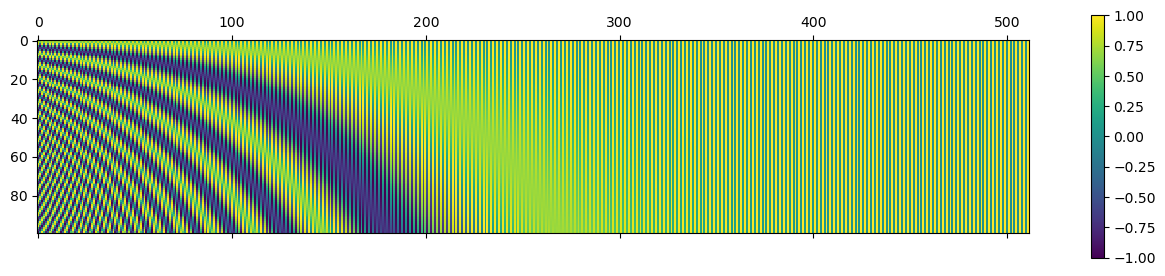

In [21]:
pos_encoding = positional_encoding(100, d_model=512, n=10000)[0]
plt.matshow(pos_encoding)
plt.colorbar()
plt.show()

## Transformer Encoder Block
The transformer block from "Attention is all you need" is implemented in the following class
<img src="https://www.researchgate.net/profile/Ehsan-Amjadian/publication/352239001/figure/fig1/AS:1033334390013952@1623377525434/Detailed-view-of-a-transformer-encoder-block-It-first-passes-the-input-through-an.jpg" width=300>

In [22]:
class Encoder(torch.nn.Module):
    def __init__(self, num_heads, d_model=512, d_ff=2048, dropout=0.0):
        super().__init__()
        self.multi_head_attn = torch.nn.MultiheadAttention(
            num_heads=num_heads, 
            embed_dim=d_model,
            batch_first=True,
            dropout=dropout
        )
        self.layer_norm1 = torch.nn.LayerNorm(d_model)
        self.layer_norm2 = torch.nn.LayerNorm(d_model)
        self.feed_forward = torch.nn.Sequential(
            torch.nn.Linear(in_features=d_model, out_features=d_ff),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(in_features=d_ff, out_features=d_model)
        )
        
    def forward(self, x, attn_mask=None):
        if attn_mask is not None:
            attn = self.multi_head_attn(query=x, key=x, value=x, attn_mask=attn_mask, need_weights=False)[0]
        else:
            attn = self.multi_head_attn(query=x, key=x, value=x, need_weights=False)[0]
        # print(attn.shape)
        
        out1 = self.layer_norm1(x + attn)
        # print(out1.shape)
        
        feed_fwd = self.feed_forward(out1)
        # print(feed_fwd.shape)
        
        out2 = self.layer_norm2(out1 + feed_fwd)
        
        return out2

In [23]:
Encoder(8)(torch.randn(32, 10, 512)).shape

torch.Size([32, 10, 512])

## Model
The model is simply composed of multiple encoder blocks. The input to these encoder blocks is the embedding ouptut added directly with the positional encoding. The model's output is a 3D tensor whose shape is `(N, S, F)` where `N` is the batch size, `S` is the sequence length, and `F` is the feature length. And due to the fact that the model is simply a sentiment classifier, the model is averaged across the `S` dimension to become `(N, F)`. Then, the `F` dimensions enter a simple linear tranformation and a sigmoid output. 

In [24]:
class SentimentModel(torch.nn.Module):
    def __init__(self, 
                 vocab_size, 
                 num_heads, 
                 d_model=512, 
                 d_ff=2048, 
                 dropout=0.0, 
                 encoder_blocks=2, 
                 device="cpu"):
        self.device = device
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.embd = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model).to(device)
        self.model = torch.nn.ModuleList([
            Encoder(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) 
            for _ in range(encoder_blocks) 
        ]).to(device)
        self.final_linear = torch.nn.Linear(in_features=d_model, out_features=1).to(device)
        
    def forward(self, x):
        x = x.to(self.device).detach()
        seq_length = x.shape[1]
        pos_encoding = positional_encoding(seq_length=seq_length, d_model=self.d_model).to(self.device)
        attn_mask = get_attn_masks(x, num_heads=self.num_heads)
        embeddings = self.embd(x)
        inputs = embeddings + pos_encoding
        hidden = inputs
        for block in self.model:
            hidden = block(hidden, attn_mask=attn_mask)
            
        hidden = torch.mean(hidden, dim=1, keepdim=False)
        outputs = torch.sigmoid(self.final_linear(hidden))
        
        return outputs

In [25]:
SentimentModel(vocab_size=vocab_size, num_heads=8)(x_train[:32]).shape

torch.Size([32, 1])

## Training Setup
Training Parameters

In [26]:
device = "cuda"
d_model = 256
d_ff = 512
num_heads = 8
lr = 0.001
dropout = 0.0
encoder_blocks = 2
x_train_device = x_train.to(device)
y_train_device = torch.FloatTensor(y_train).unsqueeze(1).to(device)
x_val_device = x_val.to(device)
y_val_device = torch.FloatTensor(y_val).unsqueeze(1).to(device)
x_test_device = x_test.to(device)
y_test_device = torch.FloatTensor(y_test).unsqueeze(1).to(device)

In [27]:
model = SentimentModel(
    vocab_size=vocab_size,
    num_heads=num_heads,
    d_model=d_model,
    d_ff=d_ff,
    dropout=dropout,
    encoder_blocks=encoder_blocks,
    device=device
)

criterion = torch.nn.BCELoss().to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [28]:
class Trainer:
    def __init__(self, model, criterion, opt):
        self.model = model
        self.criterion = criterion
        self.opt = opt
    
    def train_batch(self, x_train, y_train):
        y_hat = self.model(x_train)
        loss = self.criterion(y_hat, y_train)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.detach(), y_hat.detach()
        
    def fwd_no_grad(self, x):
        with torch.no_grad():
            y_hat = self.model(x)
        return y_hat
    
    def train(self, x_train, y_train, epochs=1, batch_size=32, x_val=None, y_val=None):
        loss_hist = []
        acc_hist = []
        val_loss_hist = []
        val_acc_hist = []
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}")
            
            cur_loss = 0.0
            cur_acc = 0.0
            trained_m = 0
            prev_str_len = 0
            dataloader = torch.utils.data.DataLoader(
                list(zip(x_train, y_train)), 
                batch_size=batch_size, shuffle=True
            )
            for x_batch, y_batch in dataloader:
                cur_m = x_batch.shape[0]
                loss, y_hat = self.train_batch(x_batch, y_batch)
                
                acc = torch.sum(((y_hat >= 0.5).int() == y_batch).int()) / cur_m
                
                cur_loss = (cur_loss * trained_m + loss * cur_m) / (trained_m + cur_m)
                cur_acc = (cur_acc * trained_m + acc * cur_m) / (trained_m + cur_m)
                trained_m += cur_m
                
                # The next part is responsible for printing the loss and accuracy
                loss_str = str(cur_loss.detach().cpu().numpy())
                acc_str = str(cur_acc.detach().cpu().numpy())
                print_str = "Loss = " + loss_str + ", Acc = " + acc_str
                # print(f"\r{print_str}", end="")
                cur_str_len = len(print_str)
                if cur_str_len < prev_str_len:
                    spaces = "".join([" "] * (prev_str_len - cur_str_len))
                    print_str += spaces
                prev_str_len = cur_str_len
                    
                print(f"\r{print_str}", end="")
            
            print()
            loss_hist.append(cur_loss.detach().cpu().numpy())
            acc_hist.append(cur_acc.detach().cpu().numpy())
            
            if x_val is not None and y_val is not None:
                dataloader = torch.utils.data.DataLoader(
                    list(zip(x_val, y_val)),
                    batch_size=batch_size
                )
                loss_ = []
                acc_ = []
                for x_batch, y_batch in dataloader:
                    y_hat = self.fwd_no_grad(x_batch)
                    cur_m = x_batch.shape[0]
                    loss_.append(
                        self.criterion(y_hat, y_batch).detach().cpu().numpy()
                    )
                    acc_.append(
                        (torch.sum(((y_hat >= 0.5).int() == y_batch).int()) / cur_m).detach().cpu().numpy()
                    )
                
                cur_val_loss = np.average(loss_)
                cur_val_acc = np.average(acc_)
                print(f"Val Loss = {cur_val_loss}")
                print(f"Val Acc = {cur_val_acc}")
                
                val_loss_hist.append(cur_val_loss)
                val_acc_hist.append(cur_val_acc)
                
        history = {
            "loss": loss_hist,
            "val_loss": val_loss_hist,
            "acc": acc_hist,
            "val_acc": val_acc_hist
        }
        
        return history

In [29]:
# history = Trainer(
#     model,
#     criterion=criterion,
#     opt=opt
# ).train(
#     x_train_device, 
#     y_train_device, 
#     batch_size=32, 
#     epochs=20, 
#     x_val=x_val_device,
#     y_val=y_val_device
# )

In [30]:
# torch.save(model.state_dict(), "model_params.pth")

## Loading Model Parameters and Model Evaluation
In the final section, the model's weights are loaded. Then, accuracy on the test data is calculated. Finally, some samples are shown. 

In [31]:
model.load_state_dict(torch.load("model_params.pth"))

<All keys matched successfully>

In [32]:
def get_accuracy(y_hat, y_true, batch_size=32):
    acc_ = []
    dataloader = torch.utils.data.DataLoader(list(zip(y_hat, y_true)), batch_size=batch_size)
    for y_hat_batch, y_true_batch in dataloader:   
        acc_.append(
            (torch.sum(((y_hat_batch >= 0.5).int() == y_true_batch).int()) / y_hat_batch.shape[0]).detach().cpu().numpy()
        )
    return np.average(acc_)

In [33]:
get_accuracy(model(x_test_device), y_test_device)

C:\Anaconda\Anaconda\envs\tf\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


0.9037162

In [101]:
def show_model_outputs(batch_size):
    random_idx = np.random.choice(x_test.shape[0], size=batch_size)
    cur_x = x_test[random_idx]
    cur_y = y_test[random_idx]
    decoded_text = utils.decode(cur_x, skip_special_tokens=True)
    x_model = x_test_device[random_idx]
    y_hat = model(x_model).detach().cpu().numpy()
    for i in range(batch_size):
        dashes = "".join(["-"] * 120)
        print(dashes)
        if y_hat[i] >= 0.5:
            print(f"Prediction: Liked Movie")
        else:
            print(f"Prediction: Disliked Movie")
        
        if cur_y[i] >= 0.5:
            print("Label: Liked Movie")
        else:
            print("Label: Disliked Movie")
            
        print()
        
        print(decoded_text[i])

In [103]:
show_model_outputs(batch_size=4)

------------------------------------------------------------------------------------------------------------------------
Prediction: Liked Movie
Label: Liked Movie

red rock west is one of those rare films that keeps you guessing the entire time as to what will happen next nicolas cage is mistaken for a contract killer as he enters a small town trying to find work dennis hopper is the bad guy and no one plays them better look for a brief appearance by country singing star dwight yoakam this is a serious drama most of the time but there are some lighter moments what matters is that you will enjoy this low budget but high quality effort
------------------------------------------------------------------------------------------------------------------------
Prediction: Liked Movie
Label: Liked Movie

the romance of the movie which is also its main theme is good and nicely presented however the surrounding of the love story is too lyric graphical and unrealistic even worse the psychology of